In [15]:
from torchvision import datasets, transforms
from skimage import io, color
from skimage.transform import resize
from torch.utils.data import DataLoader, random_split, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from collections import defaultdict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle


# from dataset import ProcessDataset

labels_map = {
    "Surprise": "0",
    "Fear": "1",
    "Disgust": "2",
    "Happy": "3",
    "Sad": "4",
    "Anger": "5",
    "Neutral": "6"
}

display_labels = [key for key in labels_map.keys()]

labels_map_inverse = {
    "0": "Surprise",
    "1": "Fear",
    "2": "Disgust",
    "3": "Happy",
    "4": "Sad",
    "5": "Anger",
    "6": "Neutral"
}

dataset_map = {
    "AffectNet": 0,
    "RAF": 1,
    "SFEW": 2
}

feature_len_map = {
    "AffectNet": 324,
    "RAF": 324,
    "SFEW": 324
}

# Modules

In [16]:
class ProcessDataset(Dataset):

    def __init__(self, directory_path):

        self.samples = []
        # process the images
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        transf_img = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])

        for emotion in ["Surprise", "Fear", "Disgust", "Happy", "Sad", "Anger", "Neutral"]:
            subirectory_path = os.path.join(directory_path, emotion)
            for fileName in os.listdir(subirectory_path):
                file_path = os.path.join(subirectory_path, fileName)
                with Image.open(file_path, mode='r') as img:
                    data = np.array(img.convert('RGB'))

                    data = cv2.resize(data, None, fx=1, fy=1, interpolation = cv2.INTER_NEAREST)
                    data = transf_img(data)

                self.samples.append((labels_map[emotion], data))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        label, image = self.samples[index]
        input_ids = image
        label_tensor = torch.tensor(int(label))

        return label_tensor, input_ids

In [17]:
class Gradients(nn.Module):
    def __init__(self):
        super(Gradients, self).__init__()
        self.gradient_x = torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.gradient_y = torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.gradient_x.weight = torch.nn.Parameter(torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]], device=device).unsqueeze(0).unsqueeze(0))
        self.gradient_y.weight = torch.nn.Parameter(torch.tensor([[-1.0, -2.0, -1.0], [0.0, 0.0, 0.0], [1.0, 2.0, 1.0]], device=device).unsqueeze(0).unsqueeze(0))

    def forward(self, x):

        d_x = self.gradient_x(x.unsqueeze(0))
        d_y = self.gradient_y(x.unsqueeze(0))

        return d_x, d_y

def hog(x, cell_size = 8, block_size = 2, nbins = 9, eps = 1e-5):

    # gray scale
    image_tensor = 0.299 * x[0, :, :] + 0.587 * x[1, :, :] + 0.114 * x[2, :, :]
    image_tensor = image_tensor.unsqueeze(0)

    # get gradients
    gradient_compute = Gradients()
    gx, gy = gradient_compute(image_tensor)

    # get gradient magnitude and direction
    magnitude = torch.sqrt(gx**2 + gy**2)
    angle = torch.atan2(gy, gx) * (180 / np.pi)

    # get histograms
    n_cells_x, n_cells_y = magnitude.shape[-1] // cell_size, magnitude.shape[-2] // cell_size

    histograms = torch.zeros((n_cells_y, n_cells_x, nbins))
    for i in range(n_cells_y):
        for j in range(n_cells_x):
            cell_magnitude = magnitude[0, 0, i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            cell_angle = angle[0, 0, i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]

            hist, _ = np.histogram(cell_angle.detach().cpu().numpy(), bins=nbins, range=(0, 180), weights=cell_magnitude.detach().cpu().numpy())
            histograms[i, j, :] = torch.tensor(hist)
    histograms = histograms.to(device)

    hog_features = torch.zeros((n_cells_y - block_size + 1, n_cells_x - block_size + 1, block_size, block_size, nbins * block_size * block_size)).to(device)
    for y in range(n_cells_y - block_size + 1):
        for x in range(n_cells_x - block_size + 1):
            block = histograms[y:y + block_size, x:x + block_size, :]
            block = block.reshape(-1)
            block = block / torch.sqrt(torch.sum(block ** 2) + eps)
            hog_features[y, x, :] = block

    return hog_features.view(-1)


In [18]:
# SE
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()

        reduced_channel = in_channels // reduction
        self.fc1 = nn.Linear(in_channels, reduced_channel)
        self.fc2 = nn.Linear(reduced_channel, in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        batch_size, channel, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(batch_size, channel)
        y = self.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y)).view(batch_size, channel, 1, 1)

        return x * y.expand_as(x)


# CNN with SE and HOG
class SE_CNN(nn.Module):
    def __init__(self, num_classes=7, if_se = False, if_hog = False, dataset = None, feature_length = 0, dropout=0.2):
        super(SE_CNN, self).__init__()

        if if_hog:
            if dataset == "AffectNet" or dataset == "RAF":
                feature_length = 17424
            elif dataset == "SFEW": # 181 143
                feature_length = 48384
            else:
                print("Invalid Dataset")


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.se1 = SEBlock(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 =  nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.se2 = SEBlock(128)


        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.se3 = SEBlock(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 =   nn.BatchNorm2d(512)
        self.relu4 =  nn.ReLU(inplace=True)
        self.maxpool4 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.se4 =  SEBlock(512)


        if dataset == "AffectNet": # 96 96
            width, height = 6, 6
        elif dataset == "RAF": # 100 100
            width, height = 6, 6
        elif dataset == "SFEW": # 181 143
            width, height = 11, 8
        else:
            print("Invalid Dataset")

        self.fc1 = nn.Linear(512 * width * height, 1024)
        self.fc_relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024 + feature_length, num_classes)


        self.if_se = if_se
        self.if_hog = if_hog

    def forward(self, x):
        original_x = x.clone()

        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        if self.if_se:
            x = self.se1(x)

        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        if self.if_se:
            x = self.se2(x)


        x = self.maxpool3(self.relu3(self.bn3(self.conv3(x))))
        if self.if_se:
            x = self.se3(x)

        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))
        if self.if_se:
            x = self.se4(x)


        x = x.view(x.size(0), -1)
        x = self.dropout(self.fc_relu(self.fc1(x)))

        if self.if_hog:
            flag = False
            for image in original_x:
                if not flag:
                    features = hog(image).unsqueeze(0)
                    flag = True
                else:
                    features = torch.cat((features, hog(image).unsqueeze(0)), dim=0)

            x = torch.cat((x,features),1)

        x = self.fc2(x)

        return x

In [19]:
# SE
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()

        reduced_channel = in_channels // reduction
        self.fc1 = nn.Linear(in_channels, reduced_channel)
        self.fc2 = nn.Linear(reduced_channel, in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        batch_size, channel, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(batch_size, channel)
        y = self.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y)).view(batch_size, channel, 1, 1)

        return x * y.expand_as(x)


# Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16, if_se = False):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )


        self.if_se = if_se

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.if_se:
            out = self.se(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out


# ResNet with SE and HOG
class SEResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7, if_se = False, if_hog = False, feature_length = 0, dataset = None):
        super(SEResNet, self).__init__()
        self.in_channels = 64

        if if_hog:
            if dataset == "AffectNet" or dataset == "RAF":
                feature_length = 17424
            elif dataset == "SFEW": # 181 143
                feature_length = 48384
            else:
                print("Invalid Dataset")

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, if_se = if_se)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, if_se = if_se)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, if_se = if_se)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, if_se = if_se)
        self.linear = nn.Linear(512 + feature_length, num_classes)
        self.if_hog = if_hog

    def _make_layer(self, block, out_channels, num_blocks, stride, if_se = False):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, if_se = if_se))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        original_x = x.clone()

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)

        if self.if_hog:
            flag = False
            for image in original_x:
                if not flag:
                    features = hog(image).unsqueeze(0)
                    flag = True
                else:
                    features = torch.cat((features, hog(image).unsqueeze(0)), dim=0)

            out = torch.cat((out,features),1)


        out = self.linear(out)
        return out


def se_resnet18(num_classes, if_se = False, if_hog=False, dataset=None):
    return SEResNet(ResNetBlock, [2, 2, 2, 2], num_classes, if_se, if_hog=if_hog, dataset = dataset)


In [20]:
# load affectnet
train_affectnet_data = ProcessDataset("./Dataset/AffectNet/Train")
train_affectnet_loader = DataLoader(train_affectnet_data, batch_size=32, shuffle=True)

valid_affectnet_data = ProcessDataset("./Dataset/AffectNet/Valid")
valid_affectnet_loader = DataLoader(valid_affectnet_data, batch_size=32, shuffle=True)

test_affectnet_data = ProcessDataset("./Dataset/AffectNet/Test")
test_affectnet_loader = DataLoader(test_affectnet_data, batch_size=32, shuffle=True)

# load raf
train_raf_data = ProcessDataset("./Dataset/RAF/Train")
train_raf_loader = DataLoader(train_raf_data, batch_size=32, shuffle=True)

valid_raf_data = ProcessDataset("./Dataset/RAF/Valid")
valid_raf_loader = DataLoader(valid_raf_data, batch_size=32, shuffle=True)

test_raf_data = ProcessDataset("./Dataset/RAF/Test")
test_raf_loader = DataLoader(test_raf_data, batch_size=32, shuffle=True)

# load sfew
train_sfew_data = ProcessDataset("./Dataset/SFEW/Train")
train_sfew_loader = DataLoader(train_sfew_data, batch_size=32, shuffle=True)

valid_sfew_data = ProcessDataset("./Dataset/SFEW/Valid")
valid_sfew_loader = DataLoader(valid_sfew_data, batch_size=32, shuffle=True)

test_sfew_data = ProcessDataset("./Dataset/SFEW/Test")
test_sfew_loader = DataLoader(test_sfew_data, batch_size=32, shuffle=True)

In [21]:
def train(model, criterion, optimizer, dataset, num_epoch = 10):

    if dataset == 0:
        train_loader, valid_loader, test_loader = train_affectnet_loader, valid_affectnet_loader, test_affectnet_loader
    elif dataset == 1:
        train_loader, valid_loader, test_loader = train_raf_loader, valid_raf_loader, test_raf_loader
    elif dataset == 2:
        train_loader, valid_loader, test_loader = train_sfew_loader, valid_sfew_loader, test_sfew_loader

    accuracies, losses = [], []

    # Training
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        for labels, images in train_loader:

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epoch}], Loss: {running_loss / len(train_loader)}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for labels, images in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the validation images: {100 * correct / total} %')

        accuracies.append(100 * correct / total)
        losses.append(running_loss / len(train_loader))


    # Testing loop
    model.eval()
    correct = 0
    total = 0
    y_test, y_predict = [], []
    with torch.no_grad():
        for labels, images in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_test.append(labels.cpu().detach().numpy())
            y_predict.append(predicted.cpu().detach().numpy())

    print(f'Accuracy of the model on the test images: {100 * correct / total} %')

    # confusion matrix
    cm = confusion_matrix(np.concatenate(y_test), np.concatenate(y_predict))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return accuracies, losses


In [22]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

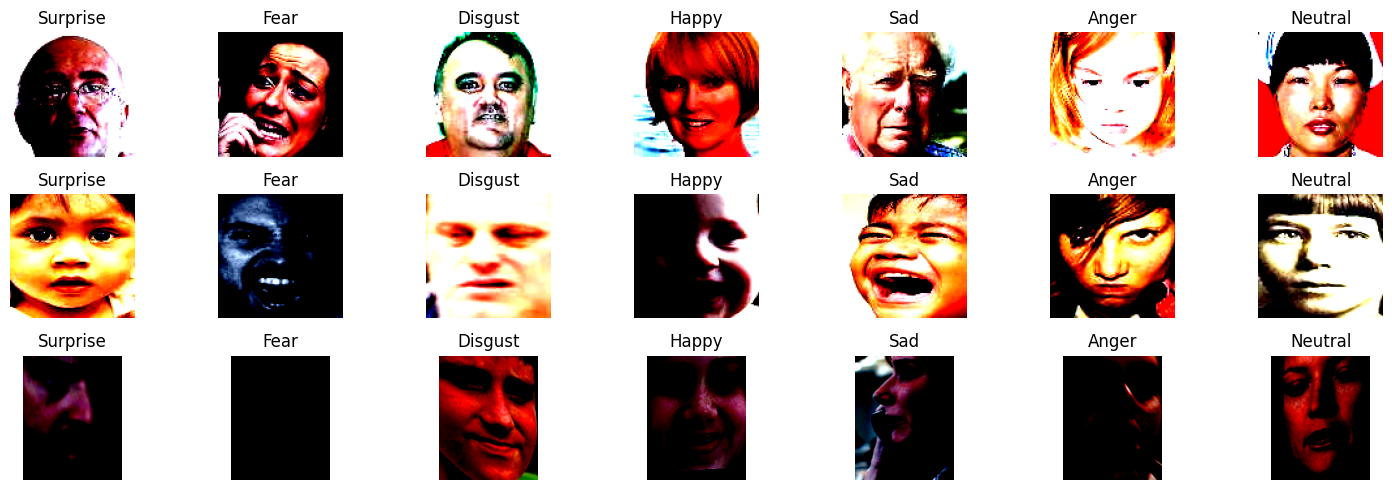

In [23]:
fig, axs = plt.subplots(len([train_affectnet_loader, train_raf_loader, train_sfew_loader]), 7, figsize=(15, 5))

for i, data in enumerate([train_affectnet_loader, train_raf_loader, train_sfew_loader]):
    emotions = []
    for j, emotion in enumerate(["Surprise", "Fear", "Disgust", "Happy", "Sad", "Anger", "Neutral"]):
        for labels, images in data:
            if labels_map_inverse[str(labels[0].item())] == emotion:
                rgb_data = np.transpose(images[0], (1, 2, 0))
                axs[i, j].imshow(rgb_data)
                axs[i, j].axis('off')
                axs[i, j].set_title(emotion)
                break
plt.tight_layout()
plt.show()

In [24]:
print("Dataset Shape:", train_affectnet_data[0][1].shape, train_raf_data[0][1].shape,  train_sfew_data[0][1].shape)

Dataset Shape: torch.Size([3, 96, 96]) torch.Size([3, 100, 100]) torch.Size([3, 181, 143])


In [26]:
print("Dataset Shape:", len(train_affectnet_data), len(train_raf_data),  len(train_sfew_data))

Dataset Shape: 17802 12269 1040


In [25]:
def training_visualize(accuracy, loss):
    for key, values in accuracy.items():
        plt.plot(values, label=f"Model:{key[0]}, SE:{bool(key[1])}, HOG:{bool(key[2])}, Concat:{bool(key[3])}")

    plt.xlabel('Epoch')
    plt.ylabel('Valid Accuracy')
    plt.title('Training Accuracy')

    plt.legend()

    plt.show()

    for key, values in loss.items():
        plt.plot(values, label=f"Model:{key[0]}, SE:{bool(key[1])}, HOG:{bool(key[2])}, Concat:{bool(key[3])}")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.legend()

    plt.show()

# AffectNet

## CNN

Epoch [1/10], Loss: 1.5710520428643835
Accuracy of the model on the validation images: 51.47982062780269 %
Epoch [2/10], Loss: 1.185277010636869
Accuracy of the model on the validation images: 53.7219730941704 %
Epoch [3/10], Loss: 1.0179135349965396
Accuracy of the model on the validation images: 58.65470852017937 %
Epoch [4/10], Loss: 0.8579121287142994
Accuracy of the model on the validation images: 62.19730941704036 %
Epoch [5/10], Loss: 0.7268276340871568
Accuracy of the model on the validation images: 61.34529147982063 %
Epoch [6/10], Loss: 0.5540557648698988
Accuracy of the model on the validation images: 64.48430493273543 %
Epoch [7/10], Loss: 0.41357263247189874
Accuracy of the model on the validation images: 64.03587443946188 %
Epoch [8/10], Loss: 0.273093346446164
Accuracy of the model on the validation images: 66.50224215246637 %
Epoch [9/10], Loss: 0.18353794534528492
Accuracy of the model on the validation images: 65.7847533632287 %
Epoch [10/10], Loss: 0.1158227322379016

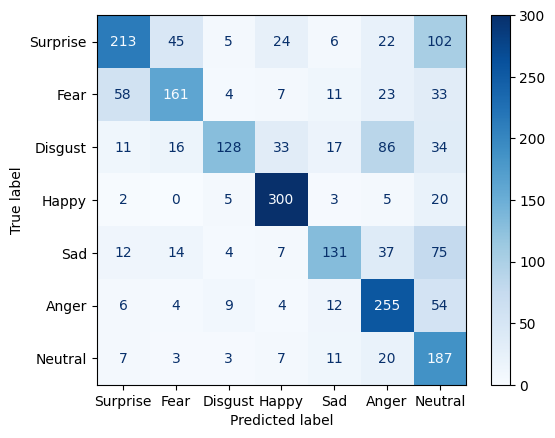

In [50]:
# CNN AffectNet
model = SE_CNN(num_classes=7, if_se = False, if_hog=False, dataset = "AffectNet").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

an_cn_acc, an_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["AffectNet"], num_epoch = 10)
with open('an_cn_acc.pkl', 'wb') as f:
    pickle.dump(an_cn_acc, f)

with open('an_cn_loss.pkl', 'wb') as f:
    pickle.dump(an_cn_loss, f)

Epoch [1/10], Loss: 1.5189776329634648
Accuracy of the model on the validation images: 49.237668161434975 %
Epoch [2/10], Loss: 1.160689756514996
Accuracy of the model on the validation images: 56.233183856502244 %
Epoch [3/10], Loss: 0.9793756056302754
Accuracy of the model on the validation images: 60.17937219730942 %
Epoch [4/10], Loss: 0.8261177155659057
Accuracy of the model on the validation images: 62.55605381165919 %
Epoch [5/10], Loss: 0.6760539072741298
Accuracy of the model on the validation images: 61.5695067264574 %
Epoch [6/10], Loss: 0.5061367482107461
Accuracy of the model on the validation images: 63.67713004484305 %
Epoch [7/10], Loss: 0.3470201529495592
Accuracy of the model on the validation images: 64.17040358744394 %
Epoch [8/10], Loss: 0.22713057074154086
Accuracy of the model on the validation images: 63.67713004484305 %
Epoch [9/10], Loss: 0.14507711853303643
Accuracy of the model on the validation images: 63.856502242152466 %
Epoch [10/10], Loss: 0.10534469759

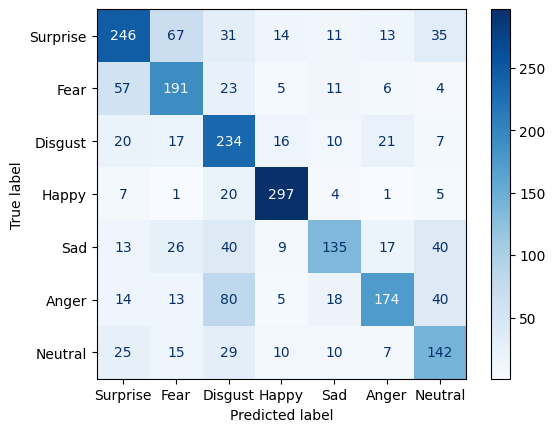

In [49]:
# SE CNN AffectNet
model = SE_CNN(num_classes=7, if_se = True, if_hog = False, dataset = "AffectNet").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

an_se_cn_acc, an_se_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["AffectNet"], num_epoch = 10)
with open('an_se_cn_acc.pkl', 'wb') as f:
    pickle.dump(an_se_cn_acc, f)

with open('an_se_cn_loss.pkl', 'wb') as f:
    pickle.dump(an_se_cn_loss, f)

Epoch [1/10], Loss: 1.4594432925621525
Accuracy of the model on the validation images: 50.762331838565025 %
Epoch [2/10], Loss: 1.1024320095616997
Accuracy of the model on the validation images: 58.20627802690583 %
Epoch [3/10], Loss: 0.9331649218684253
Accuracy of the model on the validation images: 59.28251121076233 %
Epoch [4/10], Loss: 0.7875154156980223
Accuracy of the model on the validation images: 62.91479820627803 %
Epoch [5/10], Loss: 0.6371418677230284
Accuracy of the model on the validation images: 62.42152466367713 %
Epoch [6/10], Loss: 0.5054727133824967
Accuracy of the model on the validation images: 61.52466367713004 %
Epoch [7/10], Loss: 0.35571516555344396
Accuracy of the model on the validation images: 61.0762331838565 %
Epoch [8/10], Loss: 0.23381024671975972
Accuracy of the model on the validation images: 64.84304932735427 %
Epoch [9/10], Loss: 0.14132051536381993
Accuracy of the model on the validation images: 63.7219730941704 %
Epoch [10/10], Loss: 0.090216882776

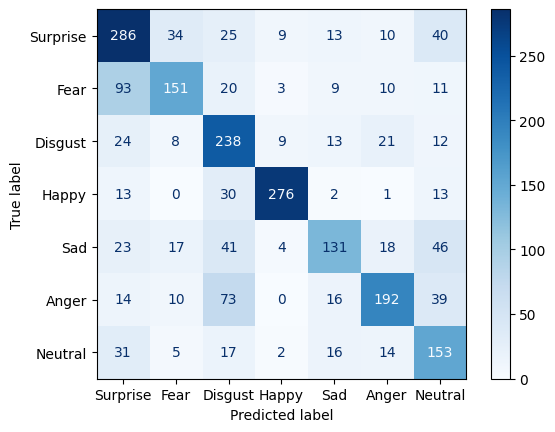

In [29]:
# SE HOG CNN AffectNet
model = SE_CNN(num_classes=7, if_se = True, if_hog = True, dataset = "AffectNet").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

an_se_hog_acc, an_se_hog_loss = train(model, criterion, optimizer, dataset = dataset_map["AffectNet"], num_epoch = 10)
with open('an_se_hog_acc.pkl', 'wb') as f:
    pickle.dump(an_se_hog_acc, f)

with open('an_se_hog_loss.pkl', 'wb') as f:
    pickle.dump(an_se_hog_loss, f)

## ResNet

Epoch [1/10], Loss: 1.653077848295763
Accuracy of the model on the validation images: 45.426008968609864 %
Epoch [2/10], Loss: 1.2624362030834013
Accuracy of the model on the validation images: 39.68609865470852 %
Epoch [3/10], Loss: 1.0379020824252596
Accuracy of the model on the validation images: 52.152466367713004 %
Epoch [4/10], Loss: 0.8644934396127396
Accuracy of the model on the validation images: 40.94170403587444 %
Epoch [5/10], Loss: 0.6828277877781078
Accuracy of the model on the validation images: 63.587443946188344 %
Epoch [6/10], Loss: 0.46908595470487535
Accuracy of the model on the validation images: 58.16143497757847 %
Epoch [7/10], Loss: 0.268427851624934
Accuracy of the model on the validation images: 54.7982062780269 %
Epoch [8/10], Loss: 0.133700207173423
Accuracy of the model on the validation images: 51.300448430493276 %
Epoch [9/10], Loss: 0.08918590326015996
Accuracy of the model on the validation images: 53.139013452914796 %
Epoch [10/10], Loss: 0.08438969053

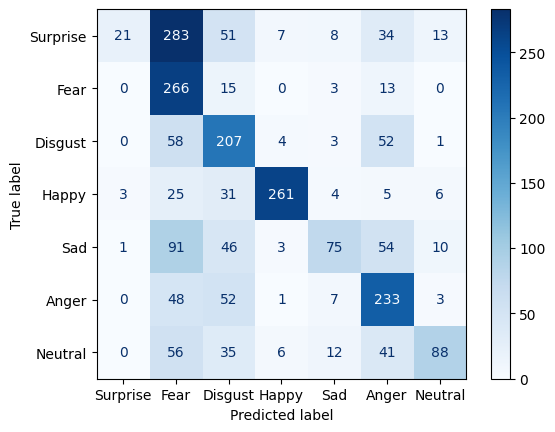

In [30]:
# ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = False, if_hog=False, dataset = "AffectNet").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

an_rn_acc, an_ren_loss = train(model, criterion, optimizer, dataset = dataset_map["AffectNet"], num_epoch = 10)
with open('an_rn_acc.pkl', 'wb') as f:
    pickle.dump(an_rn_acc, f)

with open('an_ren_loss.pkl', 'wb') as f:
    pickle.dump(an_ren_loss, f)

Epoch [1/10], Loss: 1.6942483139637343
Accuracy of the model on the validation images: 35.38116591928251 %
Epoch [2/10], Loss: 1.2898201278981016
Accuracy of the model on the validation images: 52.91479820627803 %
Epoch [3/10], Loss: 1.0752846026120966
Accuracy of the model on the validation images: 45.02242152466368 %
Epoch [4/10], Loss: 0.8722276597198507
Accuracy of the model on the validation images: 51.0762331838565 %
Epoch [5/10], Loss: 0.6625617991872065
Accuracy of the model on the validation images: 51.92825112107624 %
Epoch [6/10], Loss: 0.4015289142433574
Accuracy of the model on the validation images: 46.63677130044843 %
Epoch [7/10], Loss: 0.2106539812039323
Accuracy of the model on the validation images: 56.99551569506726 %
Epoch [8/10], Loss: 0.12313022137464055
Accuracy of the model on the validation images: 48.699551569506724 %
Epoch [9/10], Loss: 0.09356749615727303
Accuracy of the model on the validation images: 55.2017937219731 %
Epoch [10/10], Loss: 0.1051482720855

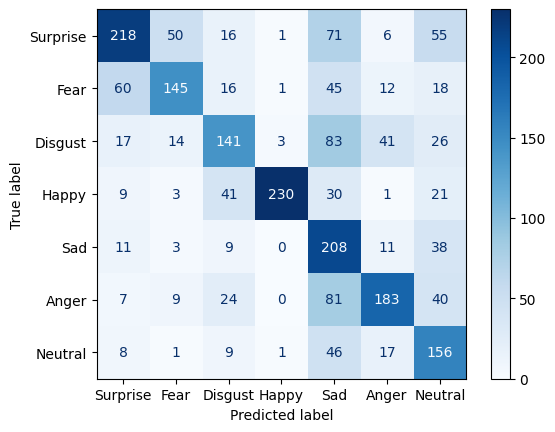

In [31]:
# SE ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = True, if_hog= False, dataset = "AffectNet").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

an_se_rn_acc, an_se_ren_loss = train(model, criterion, optimizer, dataset = dataset_map["AffectNet"], num_epoch = 10)
with open('an_se_rn_acc.pkl', 'wb') as f:
    pickle.dump(an_se_rn_acc, f)

with open('an_se_ren_loss.pkl', 'wb') as f:
    pickle.dump(an_se_ren_loss, f)

Epoch [1/10], Loss: 1.6227116738872425
Accuracy of the model on the validation images: 43.81165919282511 %
Epoch [2/10], Loss: 1.3706012598273998
Accuracy of the model on the validation images: 47.937219730941706 %
Epoch [3/10], Loss: 1.224804155702437
Accuracy of the model on the validation images: 37.62331838565022 %
Epoch [4/10], Loss: 1.1029152319076032
Accuracy of the model on the validation images: 54.17040358744394 %
Epoch [5/10], Loss: 0.9974277379054783
Accuracy of the model on the validation images: 55.426008968609864 %
Epoch [6/10], Loss: 0.8895742430935214
Accuracy of the model on the validation images: 56.72645739910314 %
Epoch [7/10], Loss: 0.7820018963818062
Accuracy of the model on the validation images: 55.11210762331839 %
Epoch [8/10], Loss: 0.6423185254769864
Accuracy of the model on the validation images: 47.98206278026906 %
Epoch [9/10], Loss: 0.48673118434217716
Accuracy of the model on the validation images: 52.42152466367713 %
Epoch [10/10], Loss: 0.328682736378

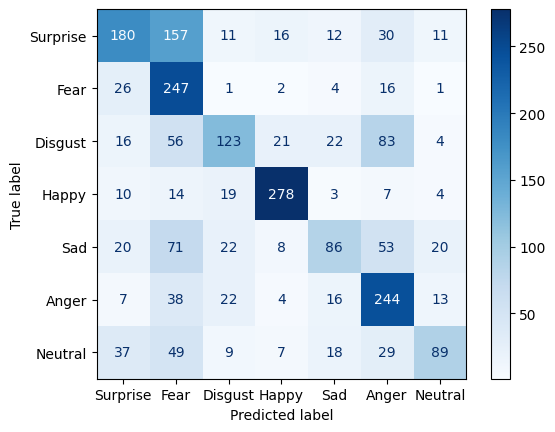

In [32]:
# SE HOG ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = True, if_hog= True, dataset = "AffectNet").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

an_se_hog_rn_acc, an_se_hog_ren_loss = train(model, criterion, optimizer, dataset = dataset_map["AffectNet"], num_epoch = 10)
with open('an_se_hog_rn_acc.pkl', 'wb') as f:
    pickle.dump(an_se_hog_rn_acc, f)

with open('an_se_hog_ren_loss.pkl', 'wb') as f:
    pickle.dump(an_se_hog_ren_loss, f)

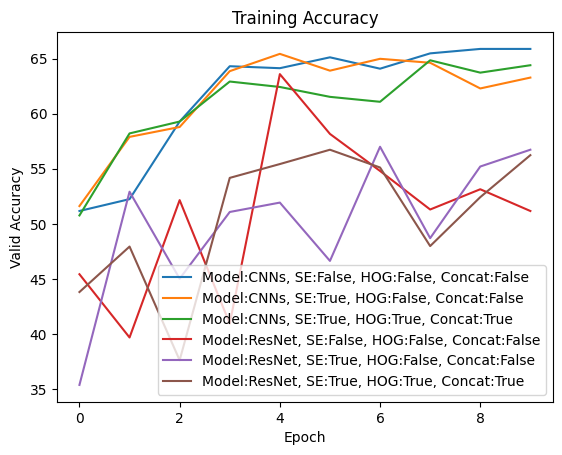

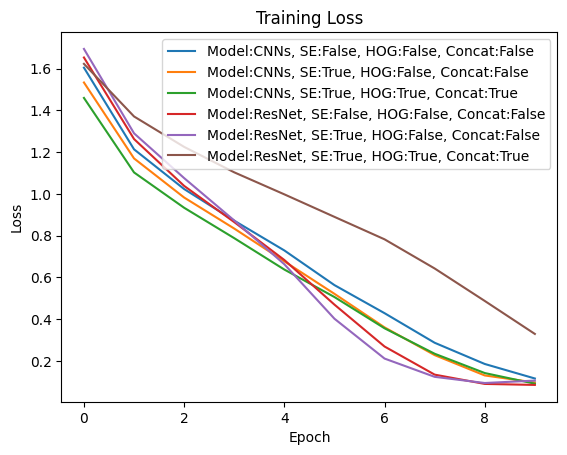

In [33]:
with open('an_cn_acc.pkl', 'rb') as f:
    an_cn_acc = pickle.load(f)

with open('an_se_cn_acc.pkl', 'rb') as f:
    an_se_cn_acc = pickle.load(f)

with open('an_se_hog_acc.pkl', 'rb') as f:
    an_se_hog_acc = pickle.load(f)

with open('an_rn_acc.pkl', 'rb') as f:
    an_rn_acc = pickle.load(f)

with open('an_se_rn_acc.pkl', 'rb') as f:
    an_se_rn_acc = pickle.load(f)

with open('an_se_hog_rn_acc.pkl', 'rb') as f:
    an_se_hog_rn_acc = pickle.load(f)

with open('an_cn_loss.pkl', 'rb') as f:
    an_cn_loss = pickle.load(f)

with open('an_se_cn_loss.pkl', 'rb') as f:
    an_se_cn_loss = pickle.load(f)

with open('an_se_hog_loss.pkl', 'rb') as f:
    an_se_hog_loss = pickle.load(f)

with open('an_ren_loss.pkl', 'rb') as f:
    an_ren_loss = pickle.load(f)

with open('an_se_ren_loss.pkl', 'rb') as f:
    an_se_ren_loss = pickle.load(f)

with open('an_se_hog_ren_loss.pkl', 'rb') as f:
    an_se_hog_ren_loss = pickle.load(f)

an_acc, an_loss = defaultdict(list), defaultdict(list)
an_acc[("CNNs", 0, 0, 0)] = an_cn_acc
an_acc[("CNNs", 1, 0, 0)] = an_se_cn_acc
an_acc[("CNNs", 1, 1, 1)] = an_se_hog_acc

an_acc[("ResNet", 0, 0, 0)] = an_rn_acc
an_acc[("ResNet", 1, 0, 0)] = an_se_rn_acc
an_acc[("ResNet", 1, 1, 1)] = an_se_hog_rn_acc


an_loss[("CNNs", 0, 0, 0)] = an_cn_loss
an_loss[("CNNs", 1, 0, 0)] = an_se_cn_loss
an_loss[("CNNs", 1, 1, 1)] = an_se_hog_loss


an_loss[("ResNet", 0, 0, 0)] = an_ren_loss
an_loss[("ResNet", 1, 0, 0)] = an_se_ren_loss
an_loss[("ResNet", 1, 1, 1)] = an_se_hog_ren_loss


training_visualize(an_acc, an_loss)

# RAF

## CNN

Epoch [1/10], Loss: 1.2637348926315706
Accuracy of the model on the validation images: 64.79791395045632 %
Epoch [2/10], Loss: 0.8584098159335554
Accuracy of the model on the validation images: 71.64276401564537 %
Epoch [3/10], Loss: 0.6974658817828944
Accuracy of the model on the validation images: 74.57627118644068 %
Epoch [4/10], Loss: 0.5737331704391787
Accuracy of the model on the validation images: 73.46805736636244 %
Epoch [5/10], Loss: 0.4718138512301569
Accuracy of the model on the validation images: 76.85788787483703 %
Epoch [6/10], Loss: 0.3767974651030575
Accuracy of the model on the validation images: 78.03129074315515 %
Epoch [7/10], Loss: 0.2794154078583233
Accuracy of the model on the validation images: 76.66232073011734 %
Epoch [8/10], Loss: 0.20664558827411383
Accuracy of the model on the validation images: 75.42372881355932 %
Epoch [9/10], Loss: 0.14143168222896443
Accuracy of the model on the validation images: 78.74837027379401 %
Epoch [10/10], Loss: 0.103520097944

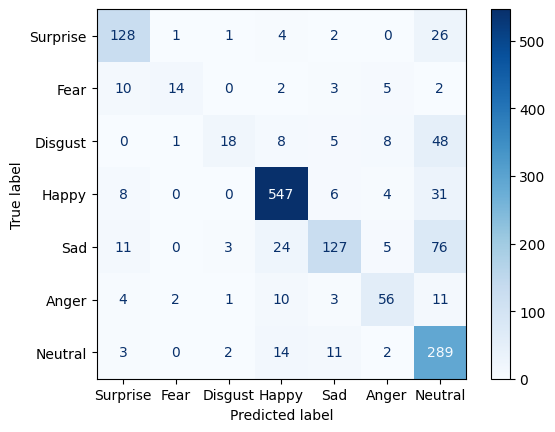

In [34]:
# CNN AffectNet
model = SE_CNN(num_classes=7, if_se = False, if_hog=False, dataset = "RAF").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

raf_cn_acc, raf_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["RAF"], num_epoch = 10)
with open('raf_cn_acc.pkl', 'wb') as f:
    pickle.dump(raf_cn_acc, f)

with open('raf_cn_loss.pkl', 'wb') as f:
    pickle.dump(raf_cn_loss, f)

Epoch [1/10], Loss: 1.2012833966873586
Accuracy of the model on the validation images: 64.79791395045632 %
Epoch [2/10], Loss: 0.8220959555668136
Accuracy of the model on the validation images: 70.86049543676663 %
Epoch [3/10], Loss: 0.658489081232498
Accuracy of the model on the validation images: 70.92568448500651 %
Epoch [4/10], Loss: 0.5324694702479368
Accuracy of the model on the validation images: 76.85788787483703 %
Epoch [5/10], Loss: 0.43074717787870515
Accuracy of the model on the validation images: 77.05345501955671 %
Epoch [6/10], Loss: 0.3183542492139774
Accuracy of the model on the validation images: 75.94524119947849 %
Epoch [7/10], Loss: 0.22664848436640264
Accuracy of the model on the validation images: 76.66232073011734 %
Epoch [8/10], Loss: 0.16035788469404602
Accuracy of the model on the validation images: 78.68318122555411 %
Epoch [9/10], Loss: 0.10547849338763626
Accuracy of the model on the validation images: 77.57496740547587 %
Epoch [10/10], Loss: 0.08617753257

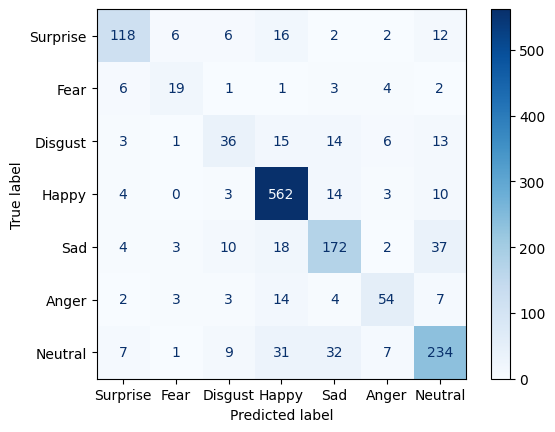

In [35]:
# SE CNN AffectNet
model = SE_CNN(num_classes=7, if_se = True, if_hog = False, dataset = "RAF").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

raf_se_cn_acc, raf_se_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["RAF"], num_epoch = 10)
with open('raf_se_cn_acc.pkl', 'wb') as f:
    pickle.dump(raf_se_cn_acc, f)

with open('raf_se_cn_loss.pkl', 'wb') as f:
    pickle.dump(raf_se_cn_loss, f)

Epoch [1/10], Loss: 1.0690145162710298
Accuracy of the model on the validation images: 70.53455019556715 %
Epoch [2/10], Loss: 0.7213182932076355
Accuracy of the model on the validation images: 72.55541069100391 %
Epoch [3/10], Loss: 0.5846221725223586
Accuracy of the model on the validation images: 75.61929595827901 %
Epoch [4/10], Loss: 0.47531679885772365
Accuracy of the model on the validation images: 72.49022164276401 %
Epoch [5/10], Loss: 0.37917853026495624
Accuracy of the model on the validation images: 77.57496740547587 %
Epoch [6/10], Loss: 0.27606991135204834
Accuracy of the model on the validation images: 78.94393741851368 %
Epoch [7/10], Loss: 0.1929712458998741
Accuracy of the model on the validation images: 78.09647979139504 %
Epoch [8/10], Loss: 0.1364914852407916
Accuracy of the model on the validation images: 78.6179921773142 %
Epoch [9/10], Loss: 0.0973669790449397
Accuracy of the model on the validation images: 77.05345501955671 %
Epoch [10/10], Loss: 0.061103938654

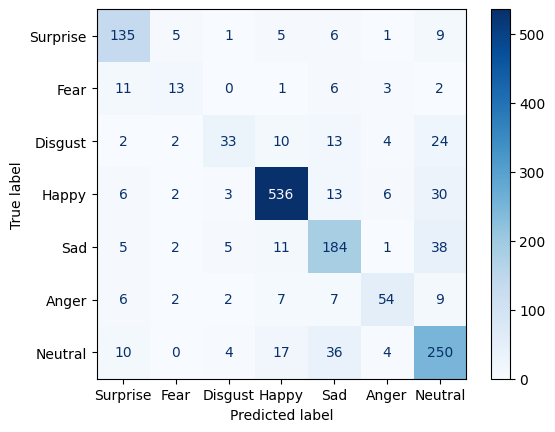

In [36]:
# SE HOG CNN AffectNet
model = SE_CNN(num_classes=7, if_se = True, if_hog = True, dataset = "RAF").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

raf_se_hog_cn_acc, raf_se_hog_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["RAF"], num_epoch = 10)
with open('raf_se_hog_cn_acc.pkl', 'wb') as f:
    pickle.dump(raf_se_hog_cn_acc, f)

with open('raf_se_hog_cn_loss.pkl', 'wb') as f:
    pickle.dump(raf_se_hog_cn_loss, f)

## ResNet

Epoch [1/10], Loss: 1.4853300615213811
Accuracy of the model on the validation images: 52.21642764015645 %
Epoch [2/10], Loss: 1.0728010170472164
Accuracy of the model on the validation images: 62.25554106910039 %
Epoch [3/10], Loss: 0.8465206893937042
Accuracy of the model on the validation images: 47.84876140808344 %
Epoch [4/10], Loss: 0.7216285131095598
Accuracy of the model on the validation images: 67.34028683181225 %
Epoch [5/10], Loss: 0.6148627725197002
Accuracy of the model on the validation images: 73.40286831812256 %
Epoch [6/10], Loss: 0.5033516788001483
Accuracy of the model on the validation images: 73.85919165580182 %
Epoch [7/10], Loss: 0.39220024466825026
Accuracy of the model on the validation images: 71.83833116036506 %
Epoch [8/10], Loss: 0.2816839143439817
Accuracy of the model on the validation images: 61.408083441981745 %
Epoch [9/10], Loss: 0.17425596935208887
Accuracy of the model on the validation images: 72.03389830508475 %
Epoch [10/10], Loss: 0.11047413525

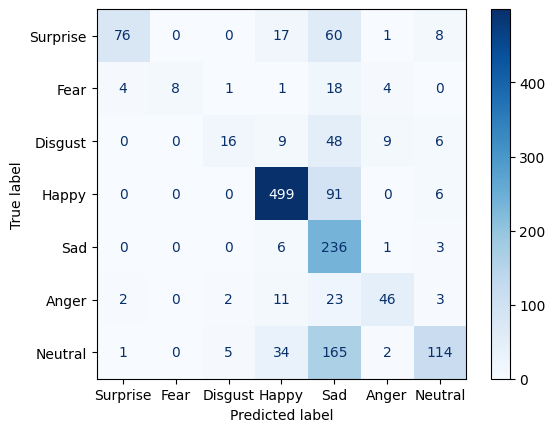

In [37]:
# ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = False, if_hog=False, dataset = "RAF").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

raf_rn_acc, raf_rn_loss = train(model, criterion, optimizer, dataset = dataset_map["RAF"], num_epoch = 10)
with open('raf_rn_acc.pkl', 'wb') as f:
    pickle.dump(raf_rn_acc, f)

with open('raf_rn_loss.pkl', 'wb') as f:
    pickle.dump(raf_rn_loss, f)

Epoch [1/10], Loss: 1.4482723924641807
Accuracy of the model on the validation images: 56.64928292046936 %
Epoch [2/10], Loss: 1.0699877894173067
Accuracy of the model on the validation images: 55.932203389830505 %
Epoch [3/10], Loss: 0.856206706026569
Accuracy of the model on the validation images: 59.97392438070404 %
Epoch [4/10], Loss: 0.7043638280592859
Accuracy of the model on the validation images: 70.40417209908735 %
Epoch [5/10], Loss: 0.5880578435026109
Accuracy of the model on the validation images: 68.77444589308996 %
Epoch [6/10], Loss: 0.44983764171289903
Accuracy of the model on the validation images: 73.72881355932203 %
Epoch [7/10], Loss: 0.32399169807710376
Accuracy of the model on the validation images: 68.2529335071708 %
Epoch [8/10], Loss: 0.21076778768717
Accuracy of the model on the validation images: 66.42764015645372 %
Epoch [9/10], Loss: 0.1361344456866694
Accuracy of the model on the validation images: 73.01173402868318 %
Epoch [10/10], Loss: 0.088596744702954

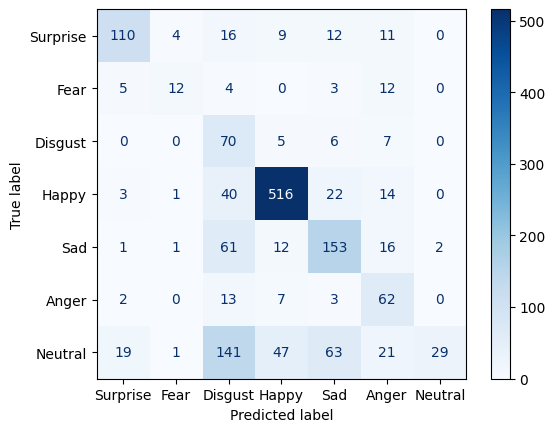

In [38]:
# SE ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = True, if_hog= False, dataset = "RAF").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

raf_se_rn_acc, raf_se_rn_loss = train(model, criterion, optimizer, dataset = dataset_map["RAF"], num_epoch = 10)
with open('raf_se_rn_acc.pkl', 'wb') as f:
    pickle.dump(raf_se_rn_acc, f)

with open('raf_se_rn_loss.pkl', 'wb') as f:
    pickle.dump(raf_se_rn_loss, f)

Epoch [1/10], Loss: 1.2067686726028721
Accuracy of the model on the validation images: 63.754889178617994 %
Epoch [2/10], Loss: 0.9035834327029685
Accuracy of the model on the validation images: 68.97001303780965 %
Epoch [3/10], Loss: 0.7942511294968426
Accuracy of the model on the validation images: 69.6870925684485 %
Epoch [4/10], Loss: 0.7209966144679735
Accuracy of the model on the validation images: 70.73011734028684 %
Epoch [5/10], Loss: 0.6574860736727715
Accuracy of the model on the validation images: 73.14211212516297 %
Epoch [6/10], Loss: 0.5992348188689599
Accuracy of the model on the validation images: 71.83833116036506 %
Epoch [7/10], Loss: 0.5491078589887669
Accuracy of the model on the validation images: 73.59843546284225 %
Epoch [8/10], Loss: 0.4892831684167807
Accuracy of the model on the validation images: 73.40286831812256 %
Epoch [9/10], Loss: 0.4192489521034683
Accuracy of the model on the validation images: 73.79400260756194 %
Epoch [10/10], Loss: 0.34249536246837

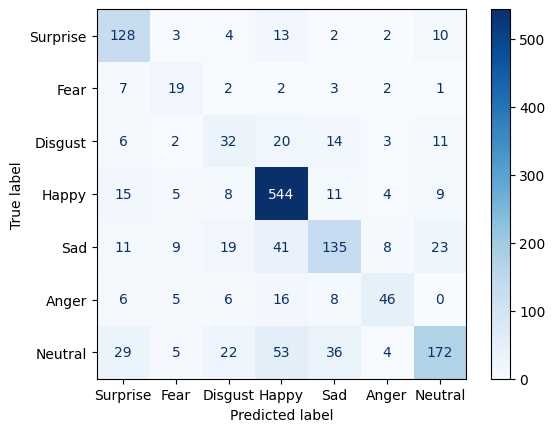

In [39]:
# SE HOG ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = True, if_hog= True, dataset = "RAF").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

raf_se_hog_rn_acc, raf_se_hog_rn_loss = train(model, criterion, optimizer, dataset = dataset_map["RAF"], num_epoch = 10)
with open('raf_se_hog_rn_acc.pkl', 'wb') as f:
    pickle.dump(raf_se_hog_rn_acc, f)

with open('raf_se_hog_rn_loss.pkl', 'wb') as f:
    pickle.dump(raf_se_hog_rn_loss, f)

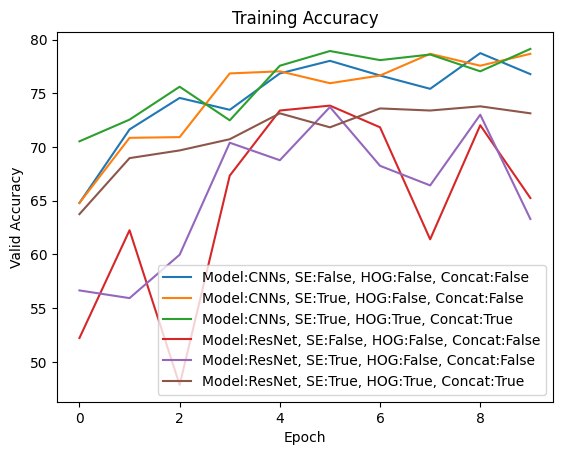

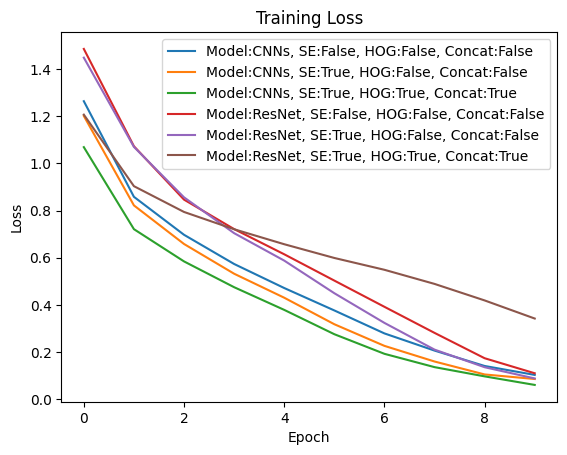

In [40]:
with open('raf_cn_acc.pkl', 'rb') as f:
    raf_cn_acc = pickle.load(f)

with open('raf_se_cn_acc.pkl', 'rb') as f:
    raf_se_cn_acc = pickle.load(f)

with open('raf_se_hog_cn_acc.pkl', 'rb') as f:
    raf_se_hog_cn_acc = pickle.load(f)

with open('raf_rn_acc.pkl', 'rb') as f:
    raf_rn_acc = pickle.load(f)

with open('raf_se_rn_acc.pkl', 'rb') as f:
    raf_se_rn_acc = pickle.load(f)

with open('raf_se_hog_rn_acc.pkl', 'rb') as f:
    raf_se_hog_rn_acc = pickle.load(f)

with open('raf_cn_loss.pkl', 'rb') as f:
    raf_cn_loss = pickle.load(f)

with open('raf_se_cn_loss.pkl', 'rb') as f:
    raf_se_cn_loss = pickle.load(f)

with open('raf_se_hog_cn_loss.pkl', 'rb') as f:
    raf_se_hog_cn_loss = pickle.load(f)

with open('raf_rn_loss.pkl', 'rb') as f:
    raf_rn_loss = pickle.load(f)

with open('raf_se_rn_loss.pkl', 'rb') as f:
    raf_se_rn_loss = pickle.load(f)

with open('raf_se_hog_rn_loss.pkl', 'rb') as f:
    raf_se_hog_rn_loss = pickle.load(f)

raf_acc, raf_loss = defaultdict(list), defaultdict(list)
raf_acc[("CNNs", 0, 0, 0)] = raf_cn_acc
raf_acc[("CNNs", 1, 0, 0)] = raf_se_cn_acc
raf_acc[("CNNs", 1, 1, 1)] = raf_se_hog_cn_acc

raf_acc[("ResNet", 0, 0, 0)] = raf_rn_acc
raf_acc[("ResNet", 1, 0, 0)] = raf_se_rn_acc
raf_acc[("ResNet", 1, 1, 1)] = raf_se_hog_rn_acc


raf_loss[("CNNs", 0, 0, 0)] = raf_cn_loss
raf_loss[("CNNs", 1, 0, 0)] = raf_se_cn_loss
raf_loss[("CNNs", 1, 1, 1)] = raf_se_hog_cn_loss


raf_loss[("ResNet", 0, 0, 0)] = raf_rn_loss
raf_loss[("ResNet", 1, 0, 0)] = raf_se_rn_loss
raf_loss[("ResNet", 1, 1, 1)] = raf_se_hog_rn_loss



training_visualize(raf_acc, raf_loss)

# SFEW

## CNN

Epoch [1/10], Loss: 2.7299397786458335
Accuracy of the model on the validation images: 26.923076923076923 %
Epoch [2/10], Loss: 1.7882117358121006
Accuracy of the model on the validation images: 36.92307692307692 %
Epoch [3/10], Loss: 1.6883939576871467
Accuracy of the model on the validation images: 26.153846153846153 %
Epoch [4/10], Loss: 1.5358780044497866
Accuracy of the model on the validation images: 37.69230769230769 %
Epoch [5/10], Loss: 1.409876660867171
Accuracy of the model on the validation images: 44.61538461538461 %
Epoch [6/10], Loss: 1.220749313181097
Accuracy of the model on the validation images: 44.61538461538461 %
Epoch [7/10], Loss: 1.0768295851620762
Accuracy of the model on the validation images: 50.0 %
Epoch [8/10], Loss: 0.837102902658058
Accuracy of the model on the validation images: 49.23076923076923 %
Epoch [9/10], Loss: 0.6809496157097094
Accuracy of the model on the validation images: 50.76923076923077 %
Epoch [10/10], Loss: 0.5401606306885228
Accuracy of

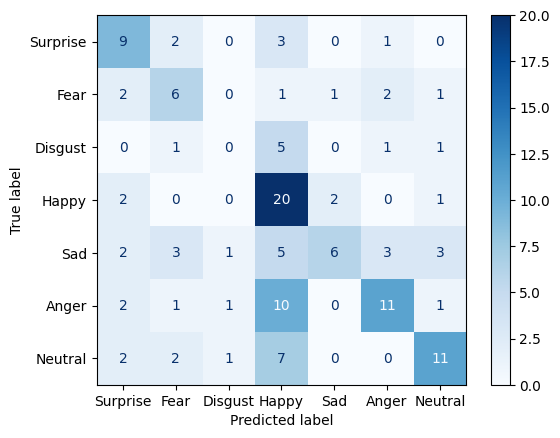

In [54]:
# CNN AffectNet
model = SE_CNN(num_classes=7, if_se = False, if_hog=False, dataset = "SFEW").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sfew_cn_acc, sfew_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["SFEW"], num_epoch = 10)
with open('sfew_cn_acc.pkl', 'wb') as f:
    pickle.dump(sfew_cn_acc, f)

with open('sfew_cn_loss.pkl', 'wb') as f:
    pickle.dump(sfew_cn_loss, f)

Epoch [1/10], Loss: 2.25190130147067
Accuracy of the model on the validation images: 23.076923076923077 %
Epoch [2/10], Loss: 1.7696073272011497
Accuracy of the model on the validation images: 33.84615384615385 %
Epoch [3/10], Loss: 1.6678136803887107
Accuracy of the model on the validation images: 32.30769230769231 %
Epoch [4/10], Loss: 1.5735288497173425
Accuracy of the model on the validation images: 38.46153846153846 %
Epoch [5/10], Loss: 1.3831017739845044
Accuracy of the model on the validation images: 47.69230769230769 %
Epoch [6/10], Loss: 1.2331437396280693
Accuracy of the model on the validation images: 48.46153846153846 %
Epoch [7/10], Loss: 1.0542685642386929
Accuracy of the model on the validation images: 52.30769230769231 %
Epoch [8/10], Loss: 0.8714696421767726
Accuracy of the model on the validation images: 52.30769230769231 %
Epoch [9/10], Loss: 0.6902077496051788
Accuracy of the model on the validation images: 50.76923076923077 %
Epoch [10/10], Loss: 0.574850919571789

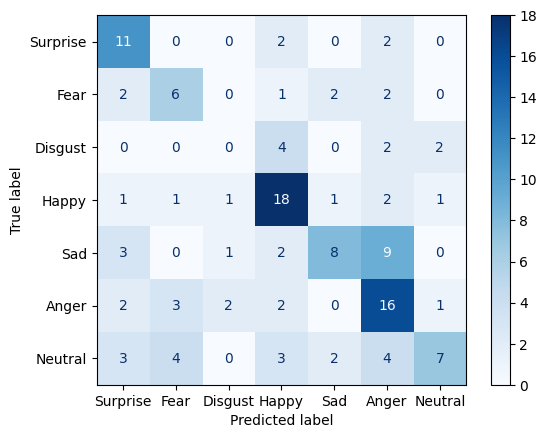

In [53]:
# SE CNN AffectNet
model = SE_CNN(num_classes=7, if_se = True, if_hog = False, dataset = "SFEW").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sfew_se_cn_acc, sfew_se_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["SFEW"], num_epoch = 10)
with open('sfew_se_cn_acc.pkl', 'wb') as f:
    pickle.dump(sfew_se_cn_acc, f)

with open('sfew_se_cn_loss.pkl', 'wb') as f:
    pickle.dump(sfew_se_cn_loss, f)

Epoch [1/10], Loss: 1.8464649012594512
Accuracy of the model on the validation images: 30.76923076923077 %
Epoch [2/10], Loss: 1.4223933545025913
Accuracy of the model on the validation images: 36.92307692307692 %
Epoch [3/10], Loss: 1.1749189766970547
Accuracy of the model on the validation images: 50.0 %
Epoch [4/10], Loss: 0.9351604635065253
Accuracy of the model on the validation images: 50.0 %
Epoch [5/10], Loss: 0.749926274473017
Accuracy of the model on the validation images: 46.15384615384615 %
Epoch [6/10], Loss: 0.5703048787333749
Accuracy of the model on the validation images: 48.46153846153846 %
Epoch [7/10], Loss: 0.44116064364259894
Accuracy of the model on the validation images: 50.76923076923077 %
Epoch [8/10], Loss: 0.31541743739084765
Accuracy of the model on the validation images: 51.53846153846154 %
Epoch [9/10], Loss: 0.19365494404778336
Accuracy of the model on the validation images: 54.61538461538461 %
Epoch [10/10], Loss: 0.1432805106495366
Accuracy of the model

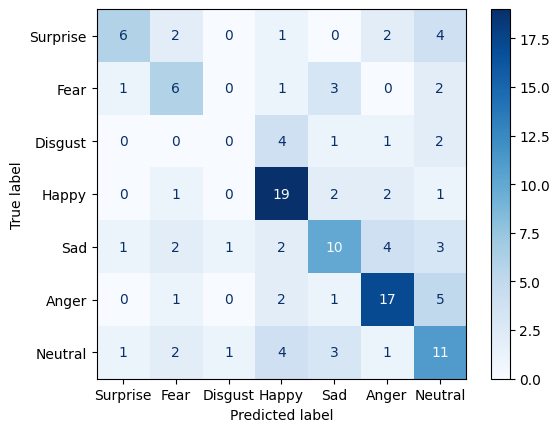

In [43]:
# SE HOG CNN AffectNet
model = SE_CNN(num_classes=7, if_se = True, if_hog = True, dataset = "SFEW").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sfew_se_hog_cn_acc, sfew_se_hog_cn_loss = train(model, criterion, optimizer, dataset = dataset_map["SFEW"], num_epoch = 10)
with open('sfew_se_hog_cn_acc.pkl', 'wb') as f:
    pickle.dump(sfew_se_hog_cn_acc, f)

with open('sfew_se_hog_cn_loss.pkl', 'wb') as f:
    pickle.dump(sfew_se_hog_cn_loss, f)

## ResNet

Epoch [1/10], Loss: 1.9708444602561719
Accuracy of the model on the validation images: 19.23076923076923 %
Epoch [2/10], Loss: 1.8306030721375437
Accuracy of the model on the validation images: 24.615384615384617 %
Epoch [3/10], Loss: 1.8135747656677708
Accuracy of the model on the validation images: 27.692307692307693 %
Epoch [4/10], Loss: 1.793100118637085
Accuracy of the model on the validation images: 27.692307692307693 %
Epoch [5/10], Loss: 1.7854557001229487
Accuracy of the model on the validation images: 30.76923076923077 %
Epoch [6/10], Loss: 1.768002091032086
Accuracy of the model on the validation images: 30.76923076923077 %
Epoch [7/10], Loss: 1.7560364080197883
Accuracy of the model on the validation images: 32.30769230769231 %
Epoch [8/10], Loss: 1.7380153157494285
Accuracy of the model on the validation images: 34.61538461538461 %
Epoch [9/10], Loss: 1.7361031698458123
Accuracy of the model on the validation images: 30.76923076923077 %
Epoch [10/10], Loss: 1.7141135714270

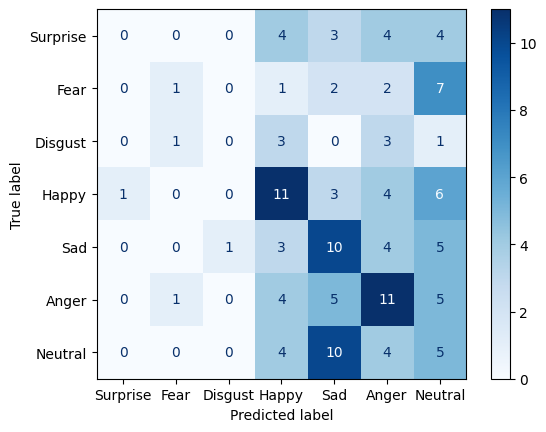

In [44]:
# ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = False, if_hog=False, dataset = "SFEW").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sfew_rn_acc, sfew_rn_loss = train(model, criterion, optimizer, dataset = dataset_map["SFEW"], num_epoch = 10)
with open('sfew_rn_acc.pkl', 'wb') as f:
    pickle.dump(sfew_rn_acc, f)

with open('sfew_rn_loss.pkl', 'wb') as f:
    pickle.dump(sfew_rn_loss, f)

Epoch [1/10], Loss: 1.9379391561854968
Accuracy of the model on the validation images: 26.153846153846153 %
Epoch [2/10], Loss: 1.8241865887786404
Accuracy of the model on the validation images: 26.923076923076923 %
Epoch [3/10], Loss: 1.7841691248344653
Accuracy of the model on the validation images: 38.46153846153846 %
Epoch [4/10], Loss: 1.7613951076160779
Accuracy of the model on the validation images: 30.0 %
Epoch [5/10], Loss: 1.7427283236474702
Accuracy of the model on the validation images: 29.23076923076923 %
Epoch [6/10], Loss: 1.7269369508280898
Accuracy of the model on the validation images: 30.76923076923077 %
Epoch [7/10], Loss: 1.696013949134133
Accuracy of the model on the validation images: 27.692307692307693 %
Epoch [8/10], Loss: 1.702970392776258
Accuracy of the model on the validation images: 34.61538461538461 %
Epoch [9/10], Loss: 1.661081870396932
Accuracy of the model on the validation images: 33.84615384615385 %
Epoch [10/10], Loss: 1.6310442360964688
Accuracy o

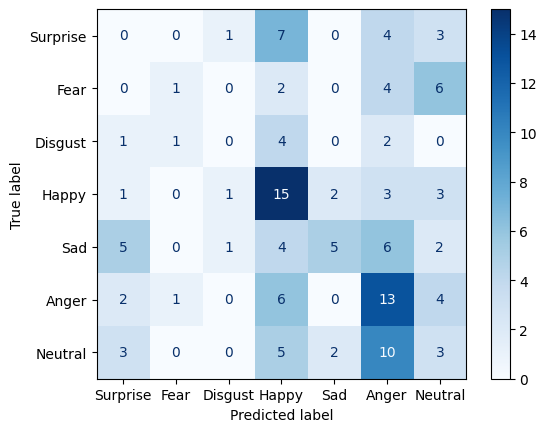

In [45]:
# SE ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = True, if_hog= False, dataset = "SFEW").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sfew_se_rn_acc, sfew_se_rn_loss = train(model, criterion, optimizer, dataset = dataset_map["SFEW"], num_epoch = 10)
with open('sfew_se_rn_acc.pkl', 'wb') as f:
    pickle.dump(sfew_se_rn_acc, f)

with open('sfew_se_rn_loss.pkl', 'wb') as f:
    pickle.dump(sfew_se_rn_loss, f)

Epoch [1/10], Loss: 1.8455734397425796
Accuracy of the model on the validation images: 31.53846153846154 %
Epoch [2/10], Loss: 1.491427977879842
Accuracy of the model on the validation images: 41.53846153846154 %
Epoch [3/10], Loss: 1.253362749562119
Accuracy of the model on the validation images: 43.07692307692308 %
Epoch [4/10], Loss: 1.0944340048414287
Accuracy of the model on the validation images: 43.07692307692308 %
Epoch [5/10], Loss: 0.9406790191476996
Accuracy of the model on the validation images: 43.84615384615385 %
Epoch [6/10], Loss: 0.8095540819746075
Accuracy of the model on the validation images: 47.69230769230769 %
Epoch [7/10], Loss: 0.7071679379000808
Accuracy of the model on the validation images: 50.0 %
Epoch [8/10], Loss: 0.6255869991851576
Accuracy of the model on the validation images: 46.15384615384615 %
Epoch [9/10], Loss: 0.5609900337277036
Accuracy of the model on the validation images: 48.46153846153846 %
Epoch [10/10], Loss: 0.48433702100406995
Accuracy of

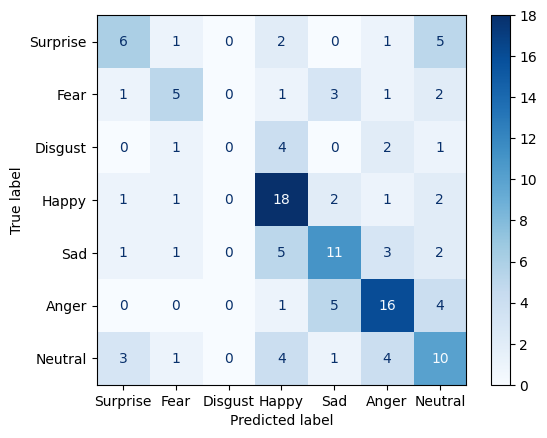

In [46]:
# SE HOG ResNet AffectNet
model = se_resnet18(num_classes=7, if_se = True, if_hog= True, dataset = "SFEW").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sfew_se_hog_rn_acc, sfew_se_hog_rn_loss = train(model, criterion, optimizer, dataset = dataset_map["SFEW"], num_epoch = 10)
with open('sfew_se_hog_rn_acc.pkl', 'wb') as f:
    pickle.dump(sfew_se_hog_rn_acc, f)

with open('sfew_se_hog_rn_loss.pkl', 'wb') as f:
    pickle.dump(sfew_se_hog_rn_loss, f)

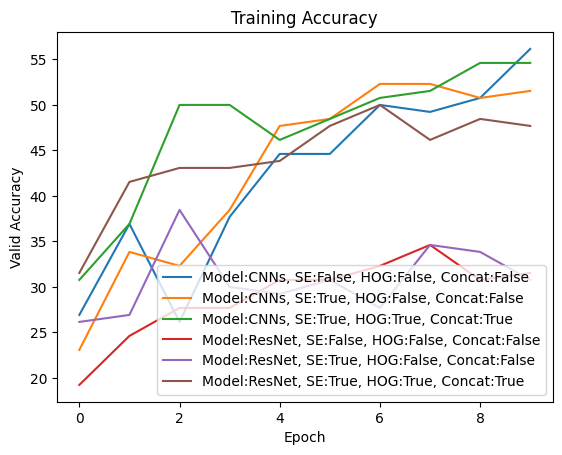

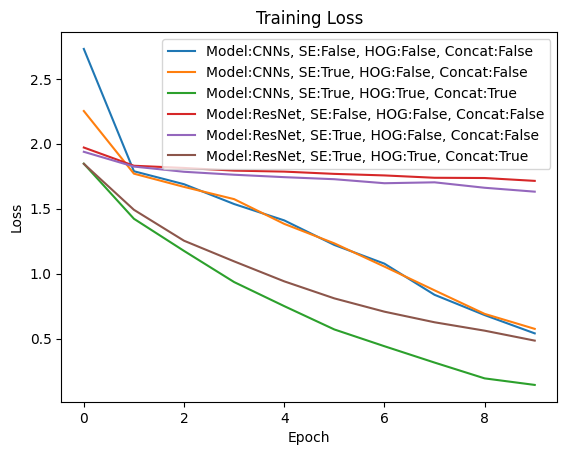

In [55]:
with open('sfew_cn_acc.pkl', 'rb') as f:
    sfew_cn_acc = pickle.load(f)

with open('sfew_se_cn_acc.pkl', 'rb') as f:
    sfew_se_cn_acc = pickle.load(f)

with open('sfew_se_hog_cn_acc.pkl', 'rb') as f:
    sfew_se_hog_cn_acc = pickle.load(f)

with open('sfew_rn_acc.pkl', 'rb') as f:
    sfew_rn_acc = pickle.load(f)

with open('sfew_se_rn_acc.pkl', 'rb') as f:
    sfew_se_rn_acc = pickle.load(f)

with open('sfew_se_hog_rn_acc.pkl', 'rb') as f:
    sfew_se_hog_rn_acc = pickle.load(f)

with open('sfew_cn_loss.pkl', 'rb') as f:
    sfew_cn_loss = pickle.load(f)

with open('sfew_se_cn_loss.pkl', 'rb') as f:
    sfew_se_cn_loss = pickle.load(f)

with open('sfew_se_hog_cn_loss.pkl', 'rb') as f:
    sfew_se_hog_cn_loss = pickle.load(f)

with open('sfew_rn_loss.pkl', 'rb') as f:
    sfew_rn_loss = pickle.load(f)

with open('sfew_se_rn_loss.pkl', 'rb') as f:
    sfew_se_rn_loss = pickle.load(f)

with open('sfew_se_hog_rn_loss.pkl', 'rb') as f:
    sfew_se_hog_rn_loss = pickle.load(f)


sfew_acc, sfew_loss = defaultdict(list), defaultdict(list)
sfew_acc[("CNNs", 0, 0, 0)] = sfew_cn_acc
sfew_acc[("CNNs", 1, 0, 0)] = sfew_se_cn_acc
sfew_acc[("CNNs", 1, 1, 1)] = sfew_se_hog_cn_acc

sfew_acc[("ResNet", 0, 0, 0)] = sfew_rn_acc
sfew_acc[("ResNet", 1, 0, 0)] = sfew_se_rn_acc
sfew_acc[("ResNet", 1, 1, 1)] = sfew_se_hog_rn_acc


sfew_loss[("CNNs", 0, 0, 0)] = sfew_cn_loss
sfew_loss[("CNNs", 1, 0, 0)] = sfew_se_cn_loss
sfew_loss[("CNNs", 1, 1, 1)] = sfew_se_hog_cn_loss


sfew_loss[("ResNet", 0, 0, 0)] = sfew_rn_loss
sfew_loss[("ResNet", 1, 0, 0)] = sfew_se_rn_loss
sfew_loss[("ResNet", 1, 1, 1)] = sfew_se_hog_rn_loss



training_visualize(sfew_acc, sfew_loss)